# A tutorial in torchAttacks (Adversarial attacks)
Here I have followed the following [example](https://medium.com/@nutanbhogendrasharma/pytorch-convolutional-neural-network-with-mnist-dataset-4e8a4265e118) for a convolution neural network.

However I followed this [tutorial](https://pytorch.org/tutorials/beginner/fgsm_tutorial.html) for the adversarial attack stuff.

## Import.STONKS()

And also defining where to put the model weights

In [157]:
import torch
import torch.nn.functional as F
from torchattacks import *
from torch import nn, optim
from torchvision import datasets, transforms, utils, models
import numpy as np
import matplotlib.pyplot as plt
import requests
import os
from PIL import Image
from torch.autograd import Variable


# Device configuration
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using {DEVICE} device")

# Path to saving the attack
save_akt_path = "/Users/Alex/Documents/results/plotables/AttacksVGG.pth"

train_again = False

Using cpu device


## Downloading data

Downloading photo from internet!

In [158]:
def download(url,fname):
    response = requests.get(url)
    with open(fname,"wb") as f:
        f.write(response.content)

# path for the downloaded images
imagePath = "../data/downloaded_pics/input.jpg"
imageDirectory = "../data/downloaded_pics/"

# Check whether the directory exists
if not os.path.exists(imageDirectory):
        os.mkdir(imageDirectory)
        print("A new directory 'downloaded_pics' was created under 'data'.")
else:
        print("Directory already exists.")
             
# Downloading the image    
download(
        "https://raw.githubusercontent.com/EliSchwartz/imagenet-sample-images/master/n02123394_Persian_cat.JPEG",
        imagePath)


# Opening the image
img = Image.open(imagePath) 

# defining labels for imagenet
labels_link = "https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json"    
labels = requests.get(labels_link).json()

#labels = {int(idx):label for idx, label in labels_json}


Directory already exists.


Pre- and deprocessing of the image

In [159]:
def preprocess(image, size=224):
    transform = transforms.Compose([
        #transforms.Resize((size,size)),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x[None]),
    ])
    return transform(image)

def deprocess(image):
    transform = transforms.Compose([
        transforms.Lambda(lambda x: x[0]),
        #transforms.Normalize(mean=[0, 0, 0], std=[4.3668, 4.4643, 4.4444]),
        #transforms.Normalize(mean=[-0.485, -0.456, -0.406], std=[1, 1, 1]),
        transforms.ToPILImage(),
    ])
    return transform(image)

## Model under attack

The model obviously also needs to be defined:

In [160]:
#Using VGG-19 pretrained model for image classification
model = models.vgg19(pretrained=True).to(DEVICE)
for param in model.parameters():
    param.requires_grad = False

model.eval()
print()

Plot image

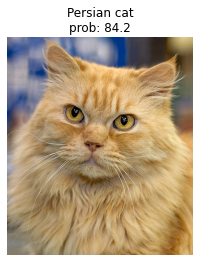

In [161]:
data = preprocess(img)
img_variable = Variable(data, requires_grad=True).to(DEVICE)

output = model(img_variable)
label_idx = torch.argmax(output).unsqueeze(0) #torch.max(output.data, 1)   #get an index(class number) of a largest element

x_pred = labels[label_idx.item()]

# Probability 
output_probs = F.softmax(output, dim=1)
x_pred_prob =  output_probs.max()*100


plt.axis('off')
plt.title(f"{x_pred}\nprob: {x_pred_prob:.1f}")
plt.imshow(np.asarray(img))


# different attacks on the model

In [162]:
atks = [
    FGSM(model, eps=8/255),
    BIM(model, eps=8/255, alpha=2/255, steps=100),
    RFGSM(model, eps=8/255, alpha=2/255, steps=100),
    CW(model, c=1, lr=0.01, steps=100, kappa=0),
    PGD(model, eps=8/255, alpha=2/225, steps=100, random_start=True),
    PGDL2(model, eps=1, alpha=0.2, steps=100),
    EOTPGD(model, eps=8/255, alpha=2/255, steps=100, eot_iter=2),
    FFGSM(model, eps=8/255, alpha=10/255),
    TPGD(model, eps=8/255, alpha=2/255, steps=100),
    MIFGSM(model, eps=8/255, alpha=2/255, steps=100, decay=0.1),
    VANILA(model),
    GN(model, std=0.1),
    APGD(model, eps=8/255, steps=100, eot_iter=1, n_restarts=1, loss='ce'),
    APGD(model, eps=8/255, steps=100, eot_iter=1, n_restarts=1, loss='dlr'),
    APGDT(model, eps=8/255, steps=100, eot_iter=1, n_restarts=1),
    FAB(model, eps=8/255, steps=100, n_classes=10, n_restarts=1, targeted=False),
    FAB(model, eps=8/255, steps=100, n_classes=10, n_restarts=1, targeted=True),
    Square(model, eps=8/255, n_queries=5000, n_restarts=1, loss='ce'),
    AutoAttack(model, eps=8/255, n_classes=10, version='standard'),
    OnePixel(model, pixels=5, inf_batch=50),
    DeepFool(model, steps=100),
    DIFGSM(model, eps=8/255, alpha=2/255, steps=100, diversity_prob=0.5, resize_rate=0.9)
]



def advAtkSingleImage(image,label, atk):

    adv_image = atk(image, label)
    output_adv = model(adv_image)
    label_idx_adv = torch.argmax(output_adv).unsqueeze(0)

    # Probability 
    x_pred_prob_adv = F.softmax(output_adv, dim=1).max()*100

    # Determind noise: avd = img + noise => noise = avd - img
    noise = adv_image - img_variable
    
    # Save info in lists
    adv_dir =  [adv_image, noise] #['a','b']#[adv_image, noise]
    pred_dir = [label_idx_adv,x_pred_prob_adv] #{"label":label_idx_adv,"prob": x_pred_prob_adv}
    
    return adv_dir, pred_dir

def saliencyMapSingleImage(model, data):
    
    # Zero all existing gradient
    model.zero_grad()
    # Set requires_grad attribute of tensor. Important for Attack
    data.requires_grad_()
    data.requires_grad = True
    
    # Get the index corresponding to the maximum score and the maximum score itself.
    scores = model(data)
    
    # Get the index corresponding to the maximum score and the maximum score itself.
    score_max_index = scores.argmax()
    score_max = scores[0,score_max_index]
   
    # Compute gradient of score_max with respect to the model
    score_max.backward()
    
    # flatten to one channel
    saliency_mean_abs = torch.mean(data.grad.data.abs(), dim=1) #torch.max(X.grad.data.abs(),dim=1)
    saliency_max_abs, _ = torch.max(data.grad.data.abs(), dim=1)

    return saliency_max_abs, saliency_mean_abs



Begin attacking!

In [163]:
if train_again == True:
    # Initialization
    adv_images = []
    pred_images = []

    for atk in atks:
        print("_"*70)
        print(atk)
        
        adv_im, adv_pred = advAtkSingleImage(img_variable, label_idx, atk)
        adv_images.append(adv_im)
        pred_images.append(adv_pred)

    # Compute Saliency map
    saliency_im,_ = saliencyMapSingleImage(model, img_variable)

    torch.save({"adv_images" : adv_images, "pred_images" : pred_images, "saliencyMap" : saliency_im}, save_akt_path)



In [165]:
print(len(adv_images))

18


## Plotting 

18


IndexError: list index out of range

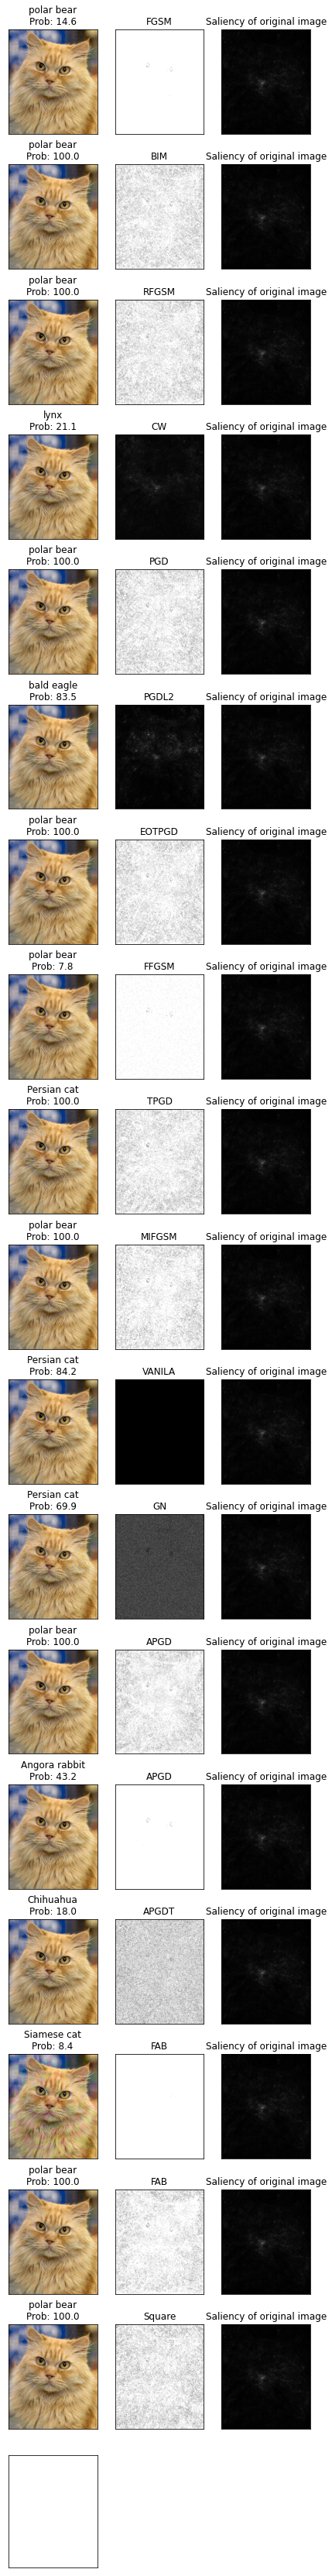

In [164]:

if train_again == False:
    # Loading!
    attack = torch.load(save_akt_path,map_location = torch.device(DEVICE))
    adv_images = attack["adv_images"]
    pred_images = attack["pred_images"]
    #saliency_im = attack["saliencyMap"]
    saliency_im,_ = saliencyMapSingleImage(model, img_variable)

    saliency_show = np.transpose(saliency_im,(1,2,0))
    cnt = 0

    fig1 = plt.figure(figsize=(7,70))
    fig1.patch.set_facecolor('white')

    for i in range(len(atks)):
        for j in range(len(adv_images[0])+1):
            cnt += 1

            plt.subplot(len(atks),len(adv_images[0]) + 1,cnt)
            plt.xticks([], [])
            plt.yticks([], [])
      
            
           
            if j == 0: # For adversarial example
                ex  = deprocess(adv_images[i][j])
                plt.title(f"{labels[pred_images[i][0].item()]}\nProb: {pred_images[i][1].item():.1f}")#title(pred_images[i][1].item())#
                plt.imshow(ex)
            elif j == 1: # For the noise 
                ex = torch.max(adv_images[i][j].abs(), dim=1)
                ex = np.transpose(ex[0].detach(), (1,2,0))
                plt.title(atks[i].__class__.__name__)
                plt.imshow(ex,cmap= 'gray')

            else: # Saliency map!
                plt.title('Saliency of original image')
                plt.imshow(saliency_show, cmap = 'gray')


            
    #plt.tight_layout()
    plt.show()


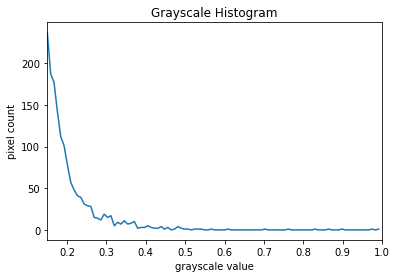

In [194]:
# histogram of saliency
ex = (saliency_show - saliency_show.min())/(saliency_show.max() -saliency_show.min())#adv_images[3][1][0].detach()

x_range = [0.15, 1]
histogram, bin_edges = np.histogram(ex, bins=100, range=(x_range[0], x_range[1]))


plt.figure()
plt.title("Grayscale Histogram")
plt.xlabel("grayscale value")
plt.ylabel("pixel count")
plt.xlim(x_range)  # <- named arguments do not work here

plt.plot(bin_edges[0:-1], histogram)  # <- or here
plt.show()




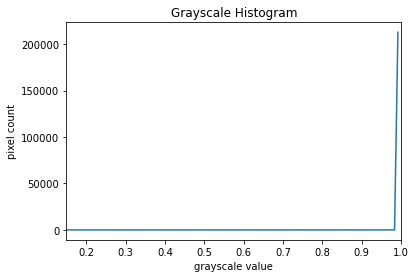

In [196]:

ex = torch.max(adv_images[0][1].abs(), dim=1)
ex = np.transpose(ex[0].detach(), (1,2,0))
ex = (ex - ex.min())/(ex.max() - ex.min())#adv_images[3][1][0].detach()


x_range = [0.0, 1]
histogram, bin_edges = np.histogram(ex, bins=100, range=(x_range[0], x_range[1]))


plt.figure()
plt.title("Grayscale Histogram")
plt.xlabel("grayscale value")
plt.ylabel("pixel count")
plt.xlim(x_range)  # <- named arguments do not work here

plt.plot(bin_edges[0:-1], histogram)  # <- or here
plt.show()

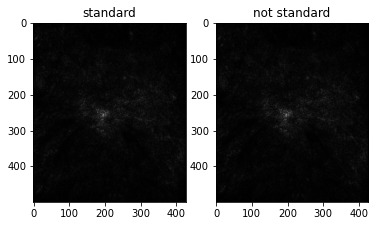

In [189]:
plt.axis('off')
plt.subplot(1,2,1)
plt.title(f"standard")
plt.imshow(ex_stanard, cmap="gray")
plt.subplot(1,2,2)
plt.title(f"not standard")
plt.imshow(saliency_show, cmap="gray")

Convert to py file

In [166]:
!jupyter nbconvert --to script torchattacks_IMAGENET.ipynb

[NbConvertApp] Converting notebook torchattacks_IMAGENET.ipynb to script
[NbConvertApp] Writing 8495 bytes to torchattacks_IMAGENET.py
